In [1]:
import functools
import importlib
import itertools
import pickle

import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.multiclass
import sklearn.neural_network
import statsmodels.api as sm
import tqdm

import lapprox.misc.utils as utils
import lapprox.models.ssa as ssa
import lapprox.models.ar as ar
import lapprox.models.arma as arma
import lapprox.models.fft as fft
import lapprox.models.semor as semor
import lapprox.joint.joint_mapping as joint_mapping
import lapprox.segments.normalize as normalize
import lapprox.misc.namespace_cutter as namespace_cutter

importlib.reload(fft)

%matplotlib inline

Using TensorFlow backend.


In [2]:
with open("data/semor_profiles.pickle", "rb") as f:
    semor_profiles = pickle.load(f)

for key, profile in semor_profiles.items():
    semor_profiles[key] = normalize.shrink_segment(profile, 20)

with open("data/segments.pickle", "rb") as f:
    segments_dict = pickle.load(f) 

## Подготавливаем данные

In [3]:
action_and_segment = []

for key, segments_array in segments_dict.items():
    action_and_segment.extend([(key, s) for s in segments_array if s.size > 30])

segments = [pair[1] for pair in action_and_segment]
actions = [pair[0] for pair in action_and_segment]

In [4]:
normalized_segments = normalize.normalize_segments(segments)
action_and_norm_segment = [(pair[0][0], pair[1])
                           for pair in zip(action_and_segment, normalized_segments)]
le = sklearn.preprocessing.LabelEncoder()
Y = le.fit_transform(actions)
X = np.array(normalized_segments)

In [5]:
models = {
    "ssa_5": ssa.Ssa(5),
    "ssa_10": ssa.Ssa(10),
    "ar_2": ar.Ar(2),
    "ar_4": ar.Ar(4),
#     "arma_2_2": arma.Arma(2, 2),
    "fft_2": fft.Fft(2),
    "fft_5": fft.Fft(5),
    "semor_run": semor.Semor(semor_profiles['run']),
    "semor_walk": semor.Semor(semor_profiles['walk']),
    "semor_up": semor.Semor(semor_profiles['up']),
    "semor_down": semor.Semor(semor_profiles['down'])
}
mapper = joint_mapping.JointMapping(models)
X_intermediate = mapper.fit_transform(X)
mapper.namespace_indices

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


{'ssa_5': array([0, 1, 2, 3, 4]),
 'ssa_10': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'ar_2': array([15, 16, 17]),
 'ar_4': array([18, 19, 20, 21, 22]),
 'fft_2': array([23, 24]),
 'fft_5': array([25, 26, 27, 28, 29]),
 'semor_run': array([30, 31, 32, 33, 34]),
 'semor_walk': array([35, 36, 37, 38, 39]),
 'semor_up': array([40, 41, 42, 43, 44]),
 'semor_down': array([45, 46, 47, 48, 49])}

## Тест простоты выборки

Собственные значения признаков

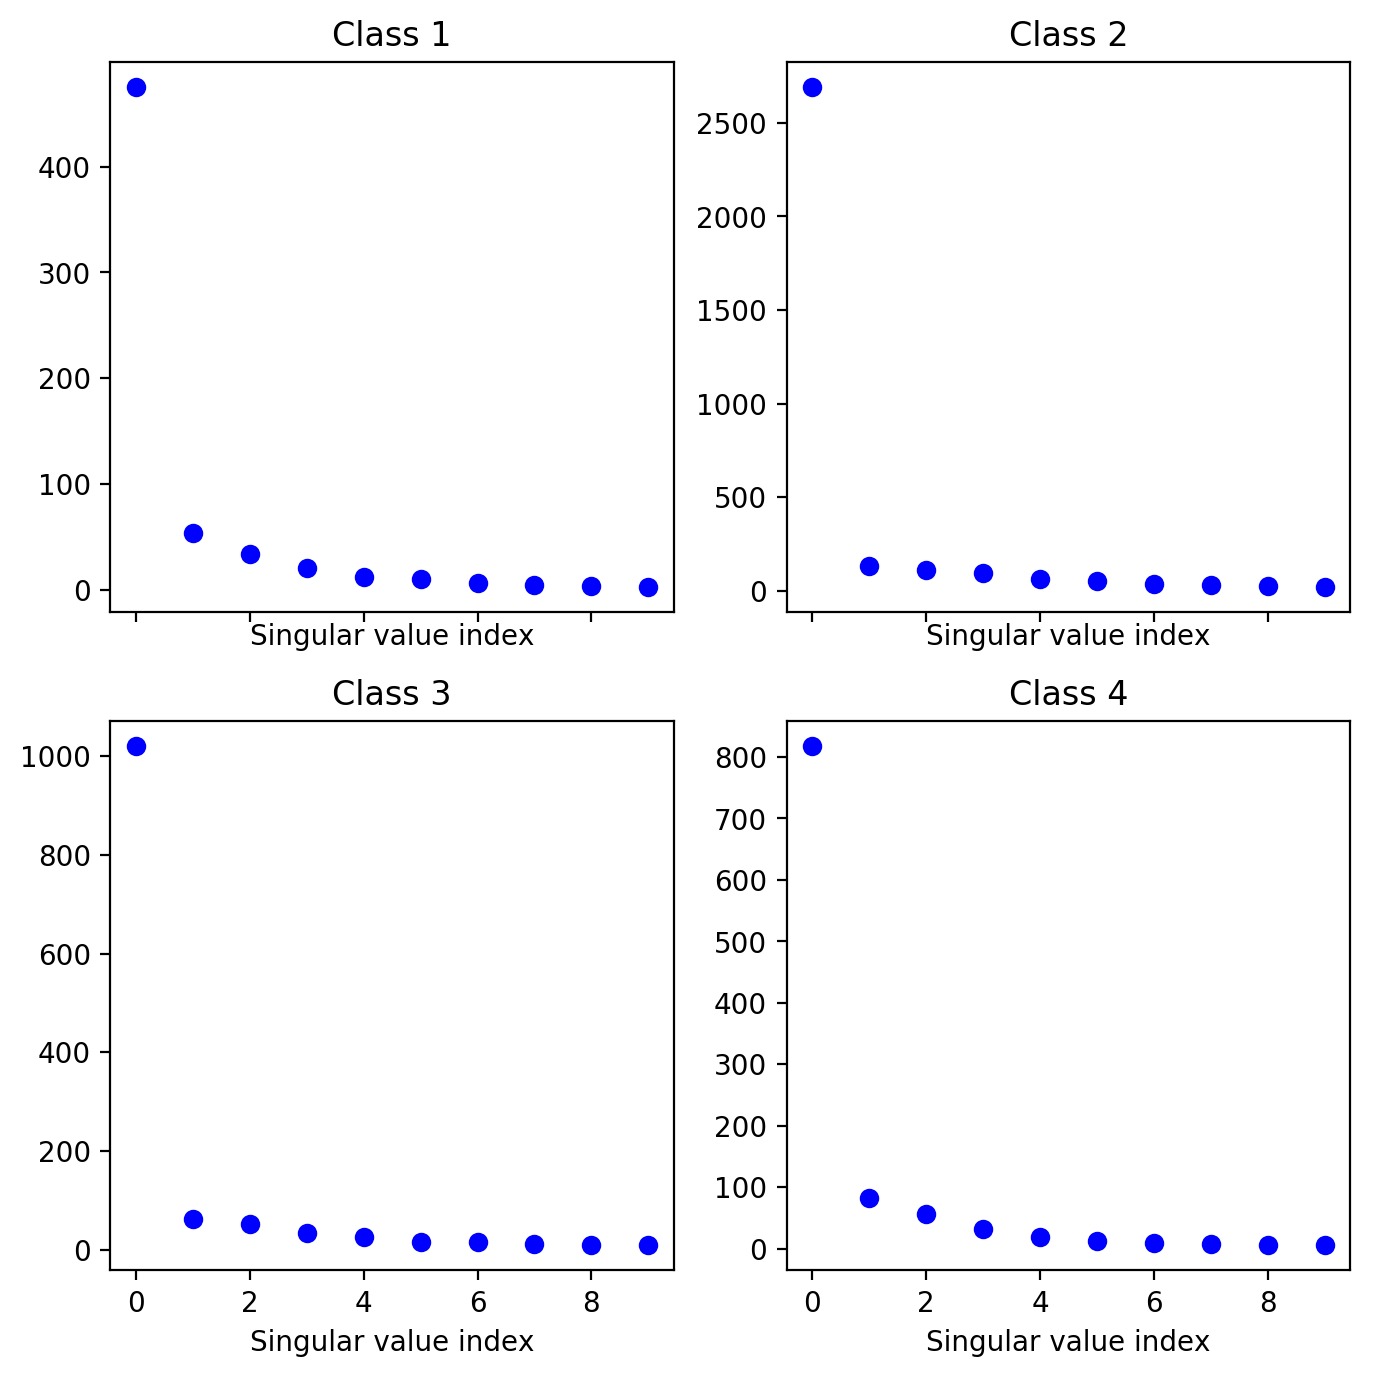

In [80]:
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(8, 8)
fig.set_dpi(200)
for idx, a in enumerate(itertools.chain.from_iterable(axes)):
    a.plot(np.linalg.svd(X_intermediate[Y == idx])[1][:10], 'bo')
    a.set_title("Class {}".format(idx + 1))
    a.set_xlabel("Singular value index")

fig.savefig("../pics/sv_analysis.png")

## Унимодальность распределений

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

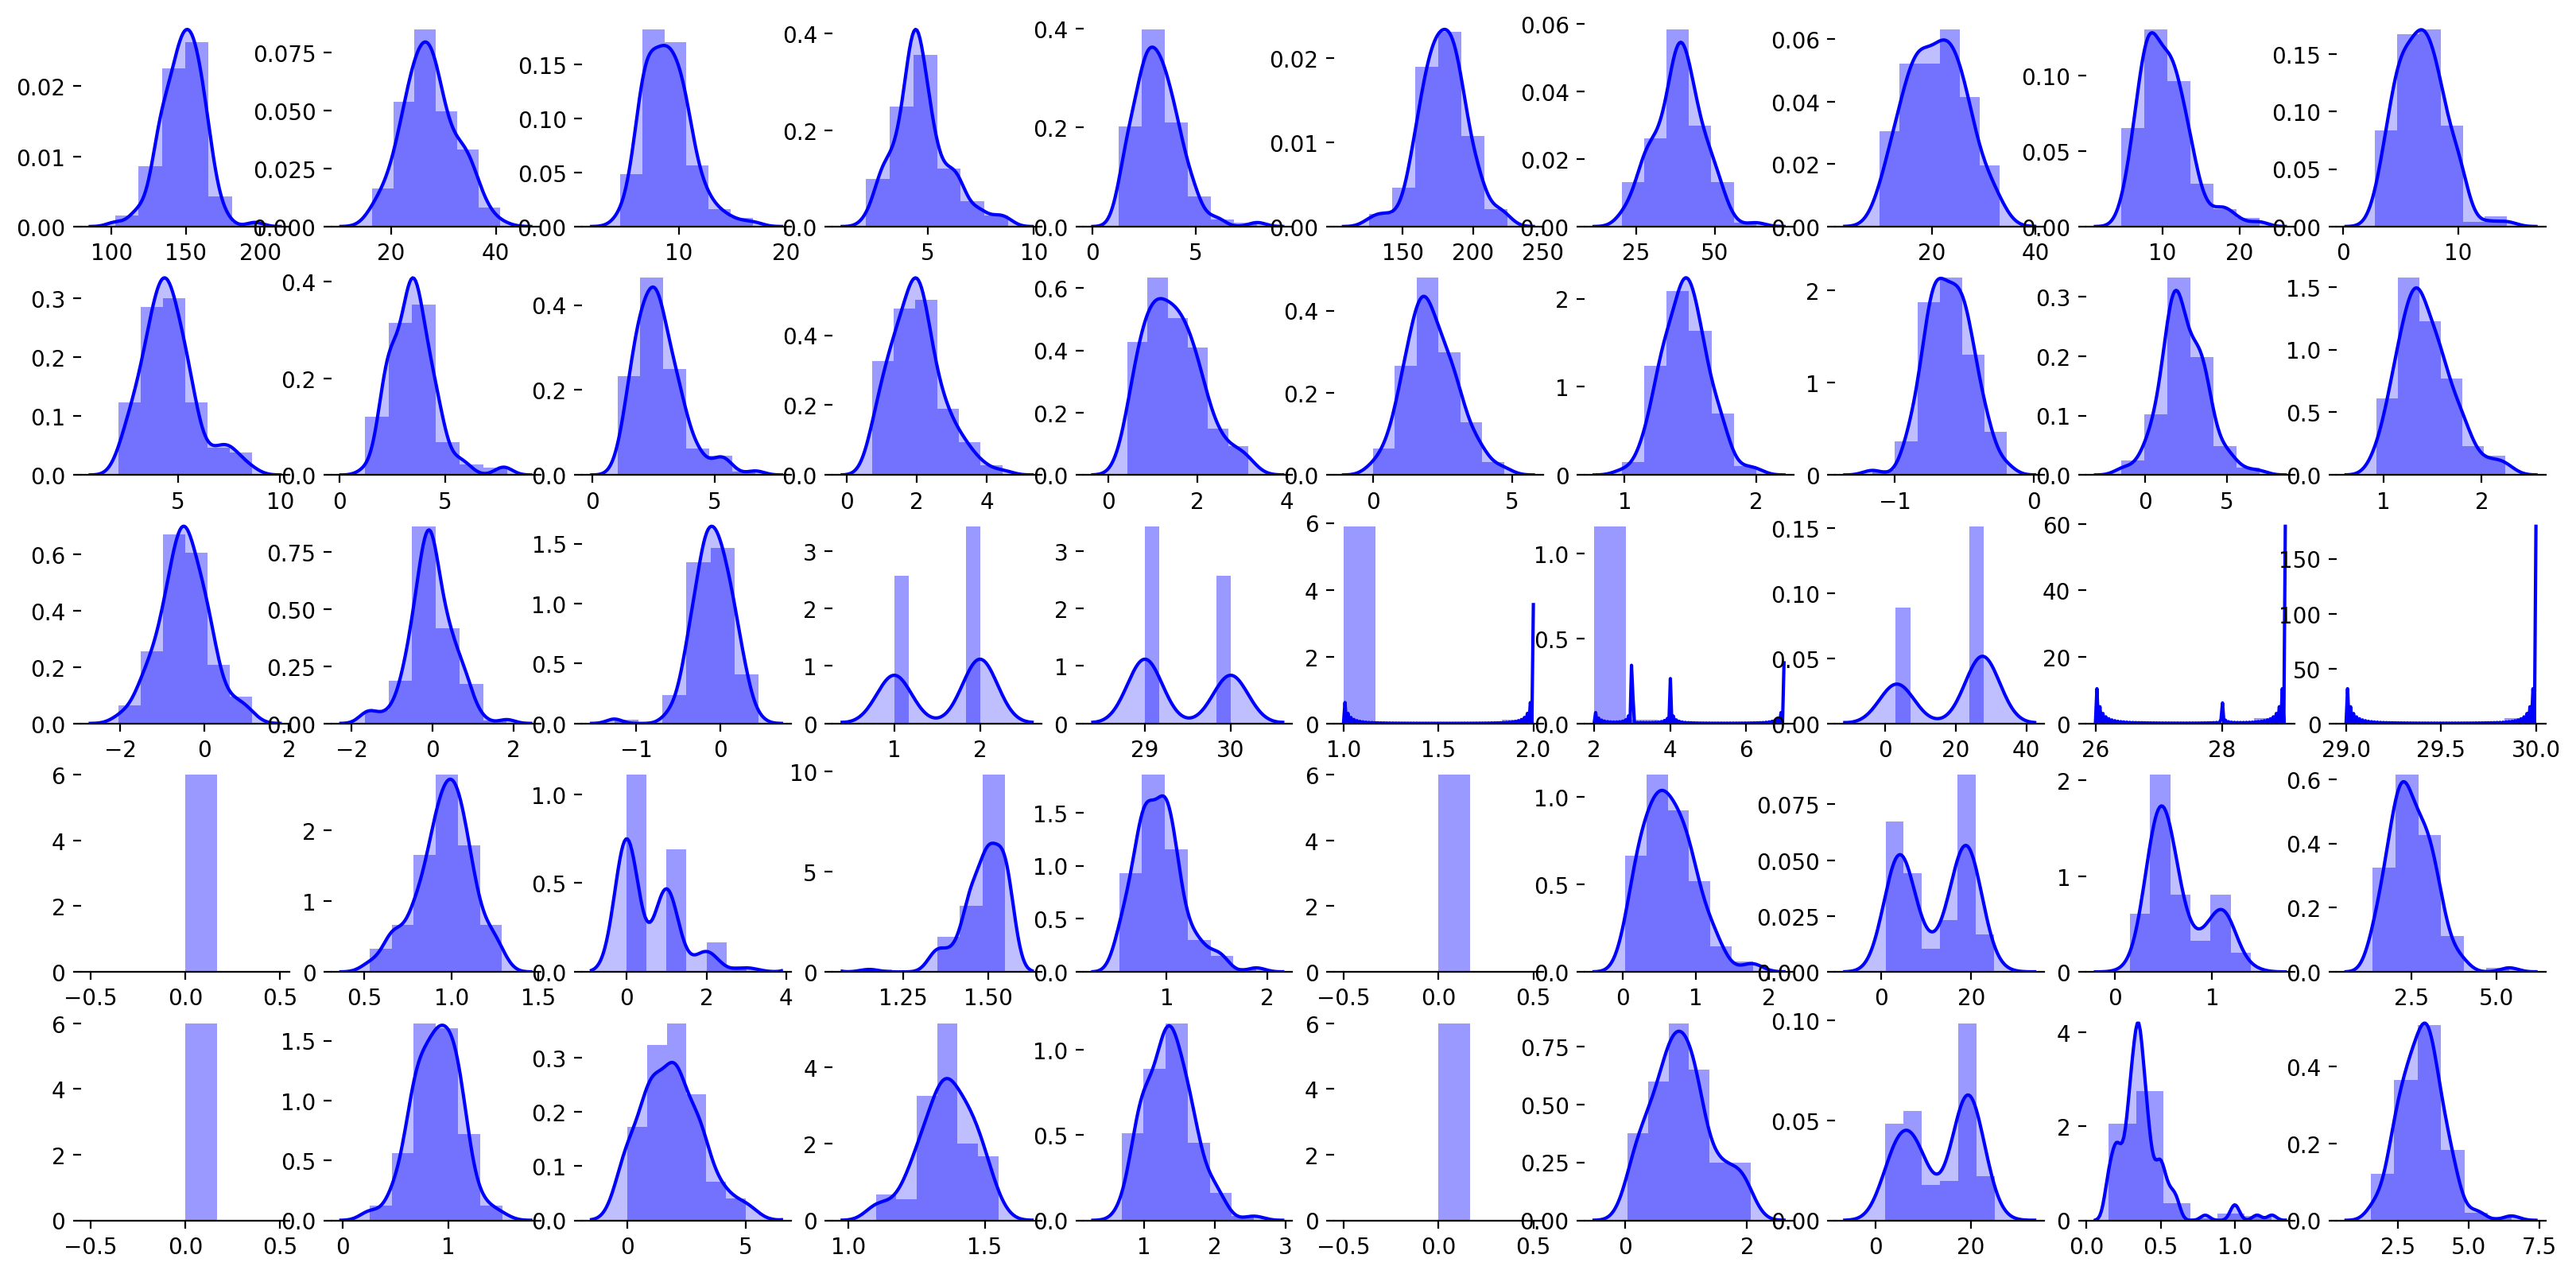

In [81]:
# for class_label in (1, ):
#     X_class = X_intermediate[Y == class_label]
#     Y_class = Y[Y == class_label]
#     plt.matshow(X_class.T @ X_class, fignum=0)

temp = X_intermediate[Y == 1]
f, axes = plt.subplots(5, 10, figsize=(20, 10), dpi=200)
sns.despine(left=True)
for idx, axis in enumerate(itertools.chain.from_iterable(axes)):
#     sns.distplot(X_intermediate[:, idx], hist=False, color="g", kde_kws={"shade": True}, ax=axis)
    sns.distplot(temp[:, idx], kde_kws={"shade": True}, color="b", ax=axis, bins=6)
plt.savefig("../pics/features_unimodality.png")

### Short

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

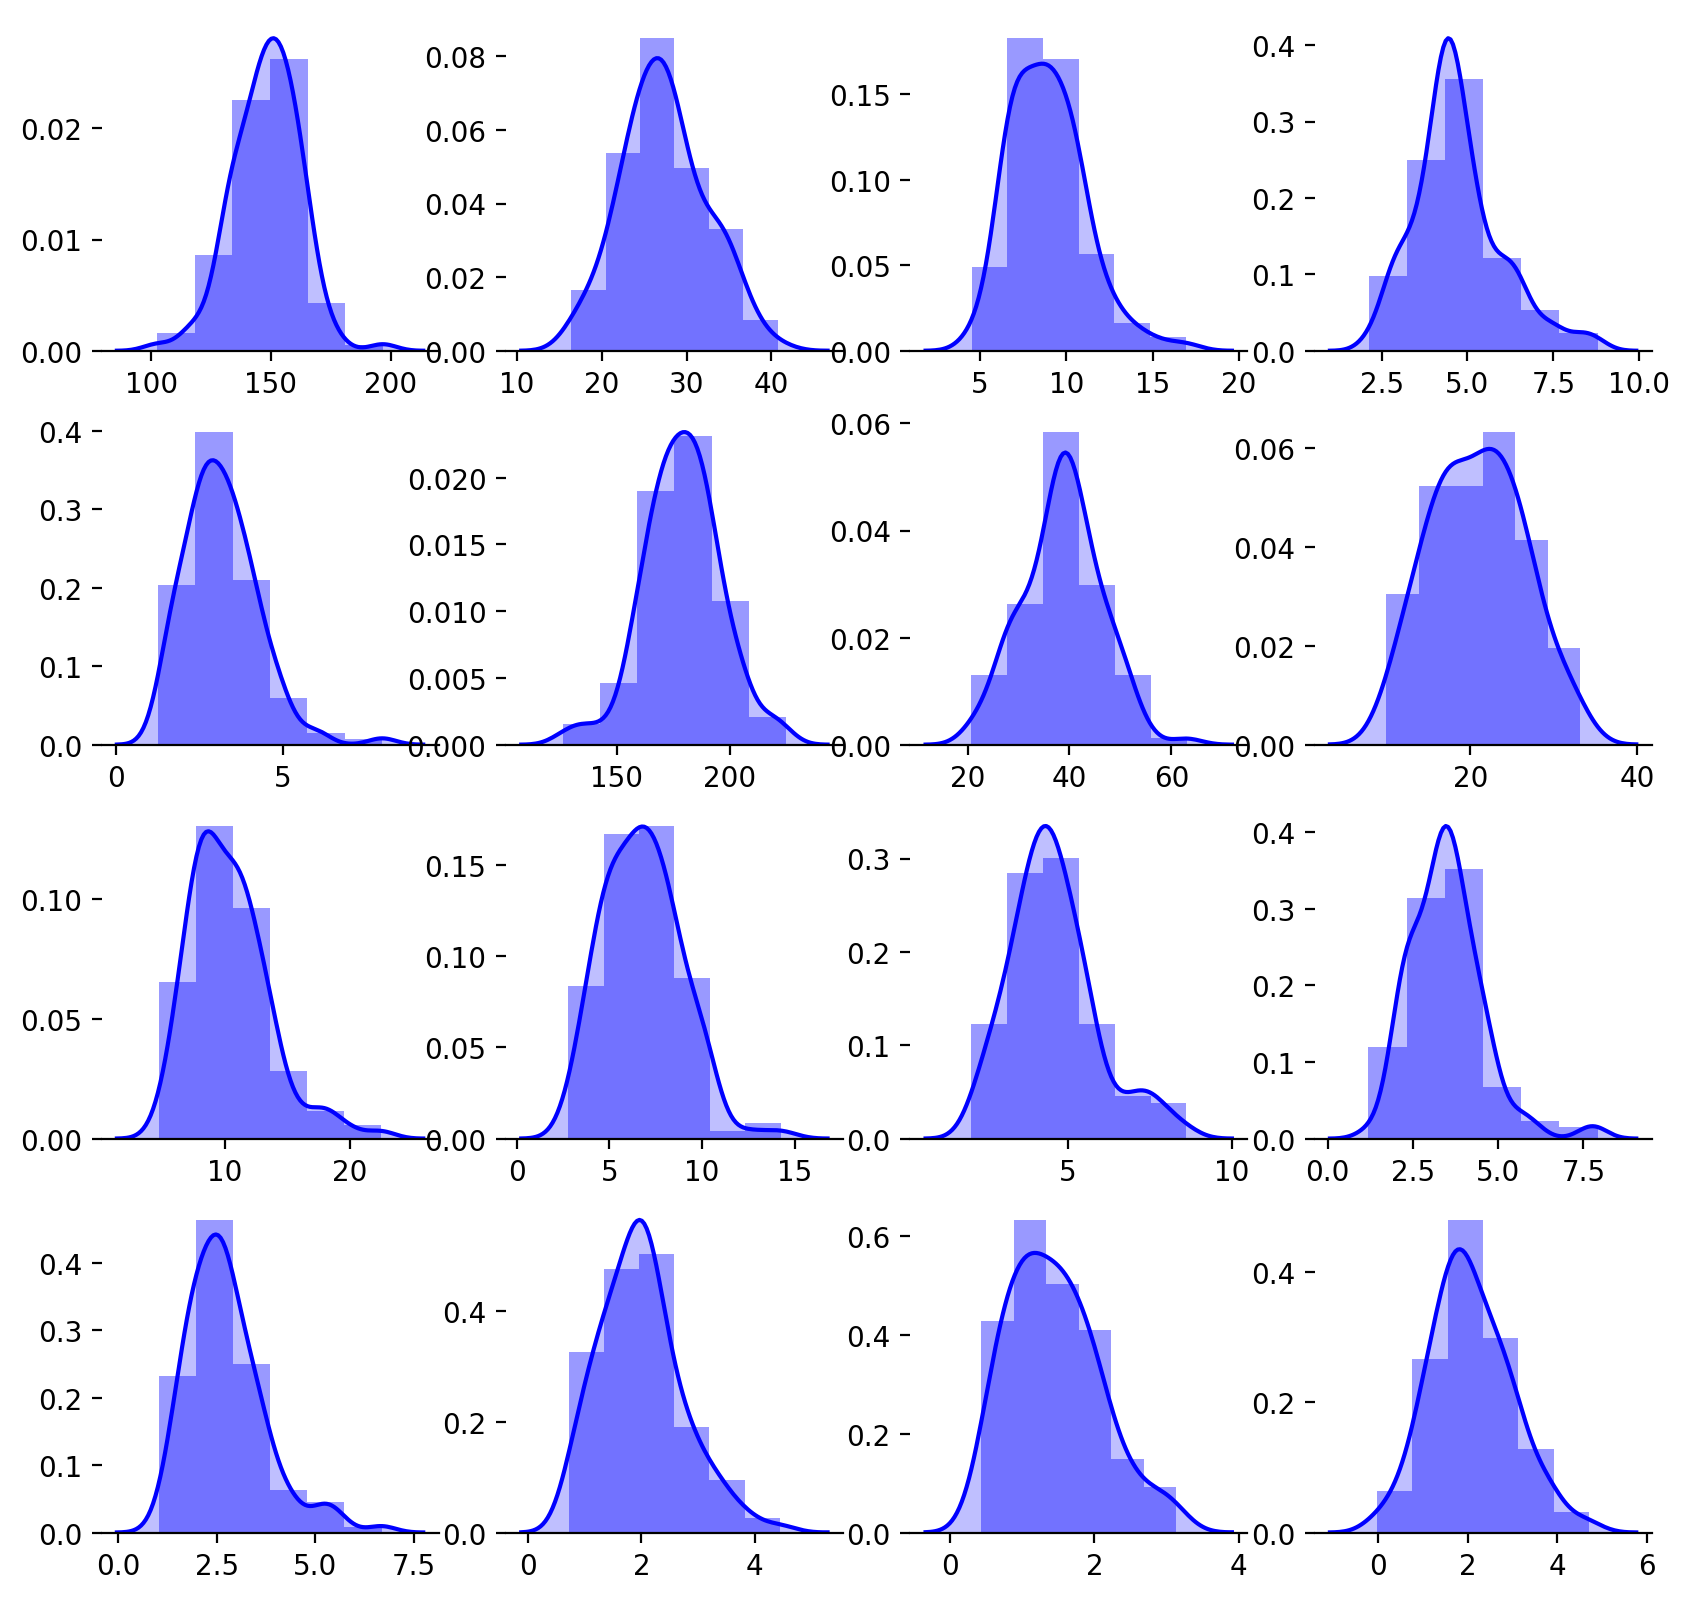

In [83]:
f, axes = plt.subplots(4, 4, figsize=(10, 10), dpi=200)
sns.despine(left=True)
for idx, axis in enumerate(itertools.islice(itertools.chain.from_iterable(axes), 16)):
#     sns.distplot(X_intermediate[:, idx], hist=False, color="g", kde_kws={"shade": True}, ax=axis)
    sns.distplot(temp[:, idx], kde_kws={"shade": True}, color="b", ax=axis, bins=6)
plt.savefig("../pics/features_unimodality_short.png")

## Дисперсия ошибки

In [7]:
Y_matrix = keras.utils.np_utils.to_categorical(Y, len(set(Y)))
clf = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000, C=0.0001)
linear_model_error = sklearn.model_selection.cross_val_score(clf, X_intermediate, Y, scoring='neg_log_loss', cv=10)
print(np.mean(linear_model_error))
clf.fit(X_intermediate, Y)
Y_pred = clf.predict_proba(X_intermediate)
err = Y_matrix - Y_pred
cov_regr = np.cov(err)

-0.5852748279760032


T test
Ttest_1sampResult(statistic=3.384177354235338e-16, pvalue=0.9999999999999998)
9.719214075700914e-15


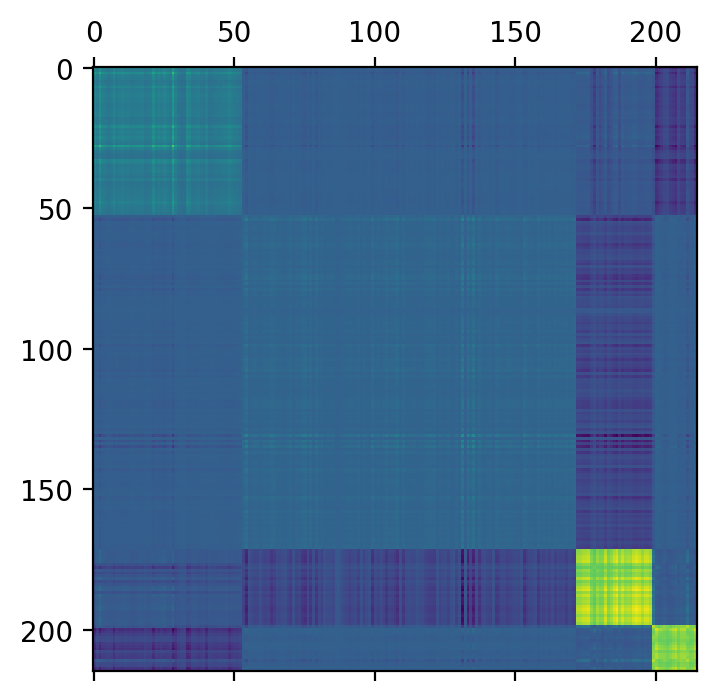

In [8]:
plt.figure(dpi=200)
plt.matshow(cov_regr, fignum=0)
np.mean(err, axis=0)
print("T test")
print(scipy.stats.ttest_1samp(err.flatten(), 0))
print(np.linalg.svd(cov_regr)[1][:5][3])

In [9]:
def grid_search_using_mapping(X_intermediate, Y, mapper, clf, clf_grid, cv=10, n_jobs=-1):
    cutter = namespace_cutter.CutNamespacesTransformer(namespaces=[], mapping=mapper)

    pipeline = sklearn.pipeline.Pipeline([
        ('namespace_cutter', cutter),
        ('clf', clf)
    ])
    grid = dict({'namespace_cutter__namespaces': utils.all_combinations(list(models))}, **clf_grid)
    gs = sklearn.model_selection.GridSearchCV(pipeline, grid, scoring='neg_log_loss', cv=cv, n_jobs=n_jobs, verbose=1,
                                              return_train_score=True)
    gs.fit(X_intermediate, Y)
    return gs

gss_clojure = functools.partial(grid_search_using_mapping, X_intermediate, Y, mapper)

grids = {}
clfs = {}
grid_search_results = {}

# Logistic regression, l2-regularization.
# clfs['lr_l2'] = sklearn.linear_model.LogisticRegressionCV(multi_class='multinomial',
#                                                           scoring='neg_log_loss')
clfs['lr_l2'] = sklearn.linear_model.LogisticRegression(penalty='l2')
grids['lr_l2'] = {}
# Logistic regression, l1-regularization.
clfs['lr_l1'] = sklearn.linear_model.LogisticRegression(solver='liblinear', penalty='l1')
grids['lr_l1'] = {}

# Elastic-net
# clfs['en'] = sklearn.linear_model.ElasticNetCV()
# grids['en'] = {}

In [10]:
# gss_clojure(clfs['en'], grids['en'], n_jobs=1)

In [11]:
# grid_search_results['lr_l2'] = gss_clojure(clfs['lr_l2'], grids['lr_l2'], n_jobs=-1)
# grid_search_results['lr_l1'] = gss_clojure(clfs['lr_l1'], grids['lr_l1'], n_jobs=-1)

In [12]:
# grid_search_results['lr_l2'].best_score_

# Нейронная сеть

In [37]:
def transform_to_inputs(Y, n_classes):
    Y_binary = np.zeros((Y.shape[0], n_classes))
    for i in range(n_classes):
        Y_binary[:, i] = (Y == i)
    
    return Y_binary

def test_neural_network(X, Y, units, cv=10):
    n_classes = len(set(Y))
    kfold = sklearn.model_selection.StratifiedKFold(n_splits=cv, random_state=1)
    
    scores = []
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = (keras.utils.np_utils.to_categorical(Y[train_index], n_classes),
                           keras.utils.np_utils.to_categorical(Y[test_index], n_classes))
        model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(units, ), activation='logistic')
        
#         model = keras.models.Sequential()
#         model.add(keras.layers.Dense(units, activation='relu', input_dim=X_train.shape[1]))
#         model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
#         model.compile(loss='categorical_crossentropy',
#                       optimizer='rmsprop')
        model.fit(X_train, Y[train_index])
        y_pred = model.predict_proba(X_test)
        scores.append(sklearn.metrics.log_loss(Y[test_index], y_pred))
#         scores.append(model.evaluate(X_test, y_test, verbose=0)
    
    return np.array(scores)

In [42]:
scores = []

for units in tqdm.trange(5, 200, 5):
    scores.append((int(units), np.array(test_neural_network(X_intermediate, Y, int(units)))))

  0%|          | 0/39 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_netwo

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  8%|▊         | 3/39 [00:03<00:36,  1.02s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neur

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▌        | 6/39 [00:06<00:35,  1.08s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neur

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

 44%|████▎     | 17/39 [00:22<00:28,  1.31s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neu

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 51%|█████▏    | 20/39 [00:27<00:26,  1.39s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neu

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

 79%|███████▉  | 31/39 [00:54<00:13,  1.74s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neu

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 87%|████████▋ | 34/39 [01:03<00:09,  1.86s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neu

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

In [43]:
n_units = np.array([p[0] for p in scores])
errors = np.array([p[1] for p in scores])

In [145]:
np.max(errors, axis=1)

array([1.06898766, 0.98340654, 0.79081317, 0.71337168, 0.53470872,
       0.51182075, 0.41814106, 0.42329628, 0.47117186, 0.4131224 ,
       0.38547336, 0.4653676 , 0.37179268, 0.40495139, 0.37667546,
       0.40716319, 0.38167102, 0.41680496, 0.41173408, 0.38521723,
       0.41047701, 0.3878517 , 0.37443226, 0.3669952 , 0.40925855,
       0.39304494, 0.41325587, 0.41940516, 0.41302302, 0.41758927,
       0.40285099, 0.39566196, 0.39791981, 0.40606717, 0.41961702,
       0.44149421, 0.44527497, 0.42291161, 0.44630673])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x127f71048>,
      dtype=object)

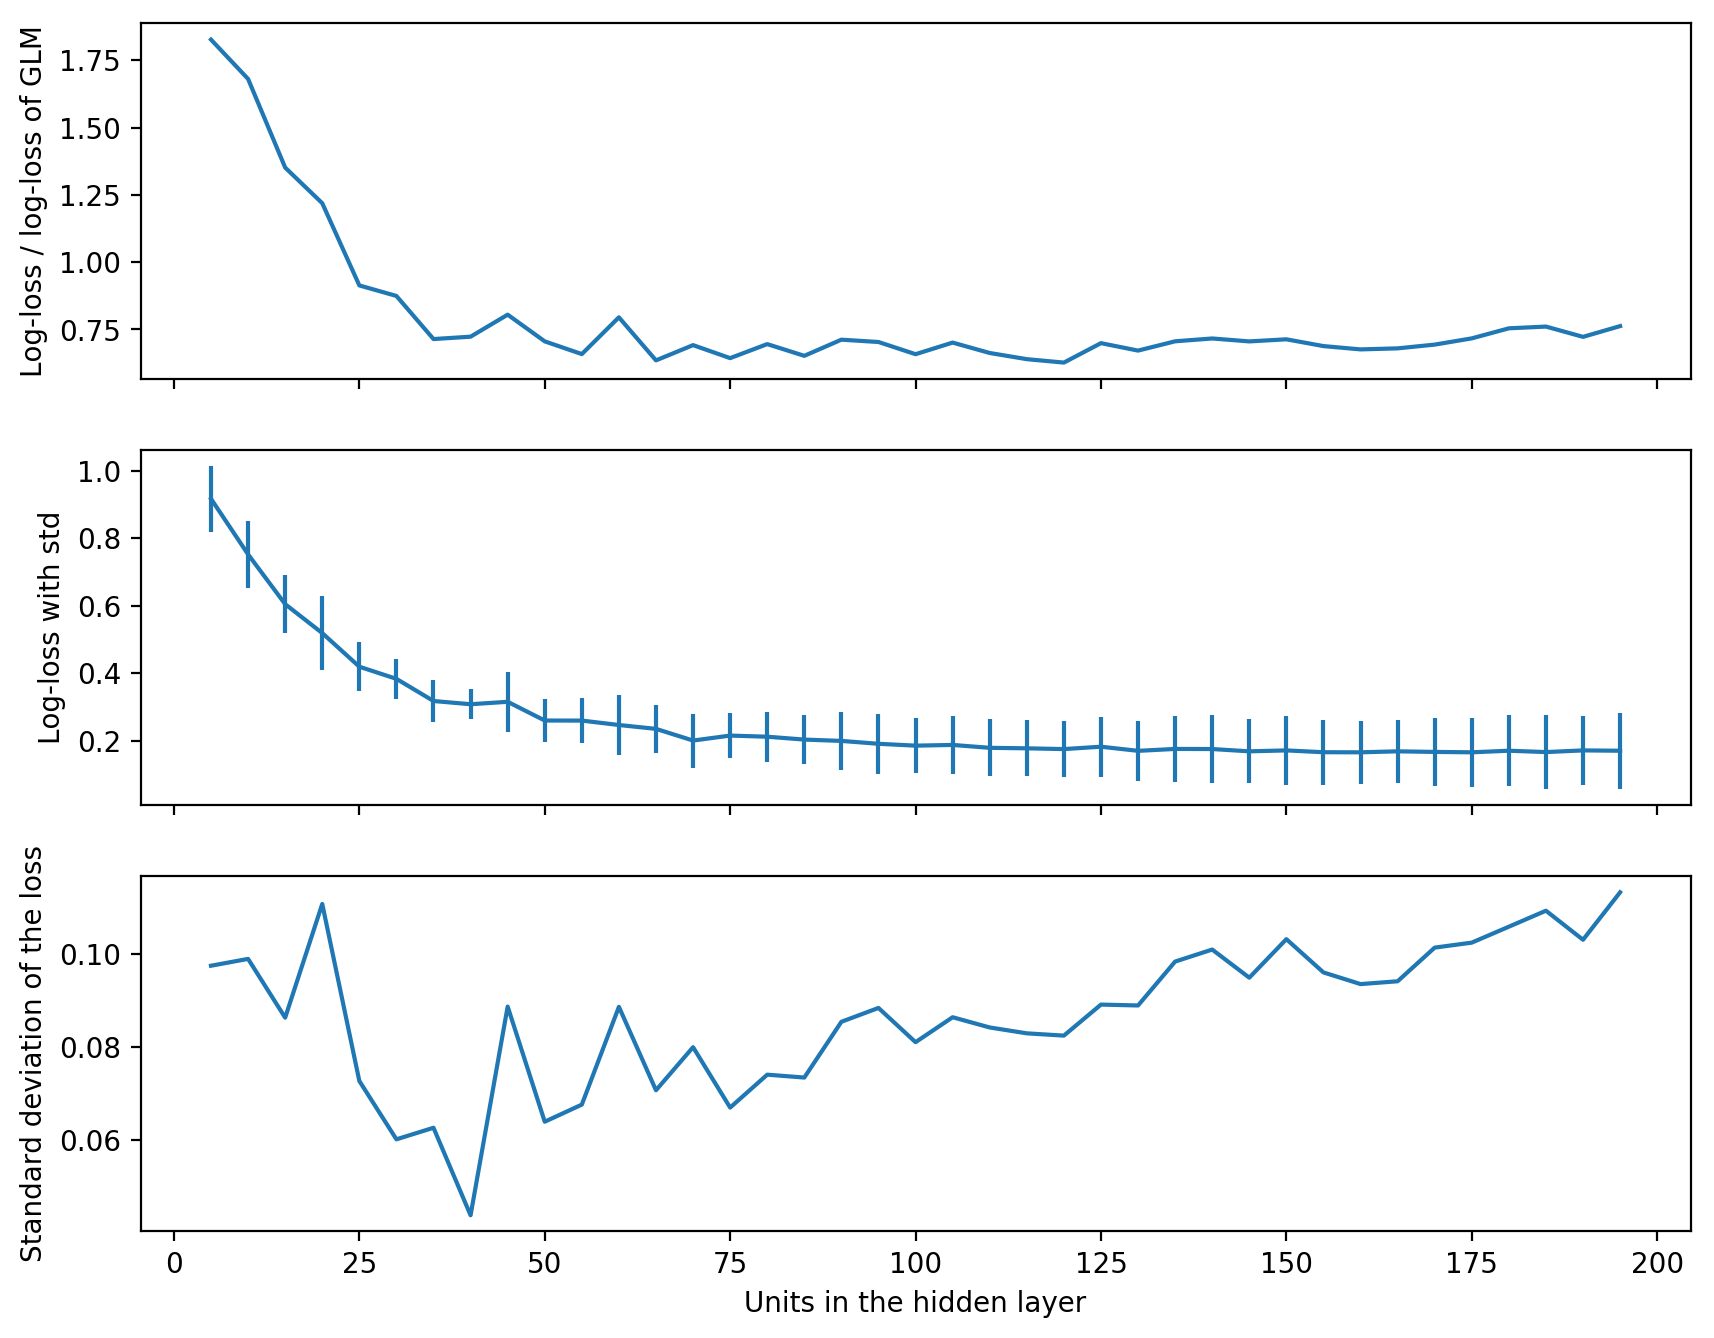

In [146]:
f, axes = plt.subplots(3, 1, dpi=200, sharex=True)
f.set_size_inches(10, 8)
axes[0].plot(n_units, -np.max(errors, axis=1) / np.mean(linear_model_error))
axes[0].set_ylabel("Log-loss / log-loss of GLM")
axes[1].errorbar(x=n_units, y=np.mean(errors, axis=1), yerr=np.std(errors, axis=1))
axes[1].set_ylabel("Log-loss with std")
axes[2].plot(n_units, np.std(errors, axis=1))
axes[2].set_ylabel("Standard deviation of the loss")
# f.xlabel("Number of neurons")
# axes[0].ylabel("Log-loss")
plt.savefig("../pics/loss_and_std_of_n_units.png")
plt.xlabel("Units in the hidden layer")
axes

In [ ]:
# plt.figure(dpi=200)
# plt.errorbar(x=[p[0] for p in scores], y=[np.min(p[1]) for p in scores])
# plt.xlabel("Number of units in the hidden layer")
# plt.ylabel("Negative log-loss")
# plt.savefig("../pics/loss_of_n_units.png")

## Логистическая регрессия на всех признаках

In [89]:
grid = {
    'C': 10 ** np.linspace(-3, 4, 40)
}
clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')
gs = sklearn.model_selection.GridSearchCV(clf, grid, scoring='neg_log_loss', cv=10, n_jobs=-1, verbose=1,
                                          return_train_score=True)
gs.fit(X_intermediate, Y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.8s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.51178e-03, 2.28546e-03, 3.45511e-03, 5.22335e-03,
       7.89652e-03, 1.19378e-02, 1.80472e-02, 2.72833e-02, 4.12463e-02,
       6.23551e-02, 9.42668e-02, 1.42510e-01, 2.15443e-01, 3.25702e-01,
       4.92388e-01, 7.44380e-01, 1.12534e+00, 1.70125e+00, 2.57191e... 8.37678e+02, 1.26638e+03,
       1.91448e+03, 2.89427e+03, 4.37548e+03, 6.61474e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

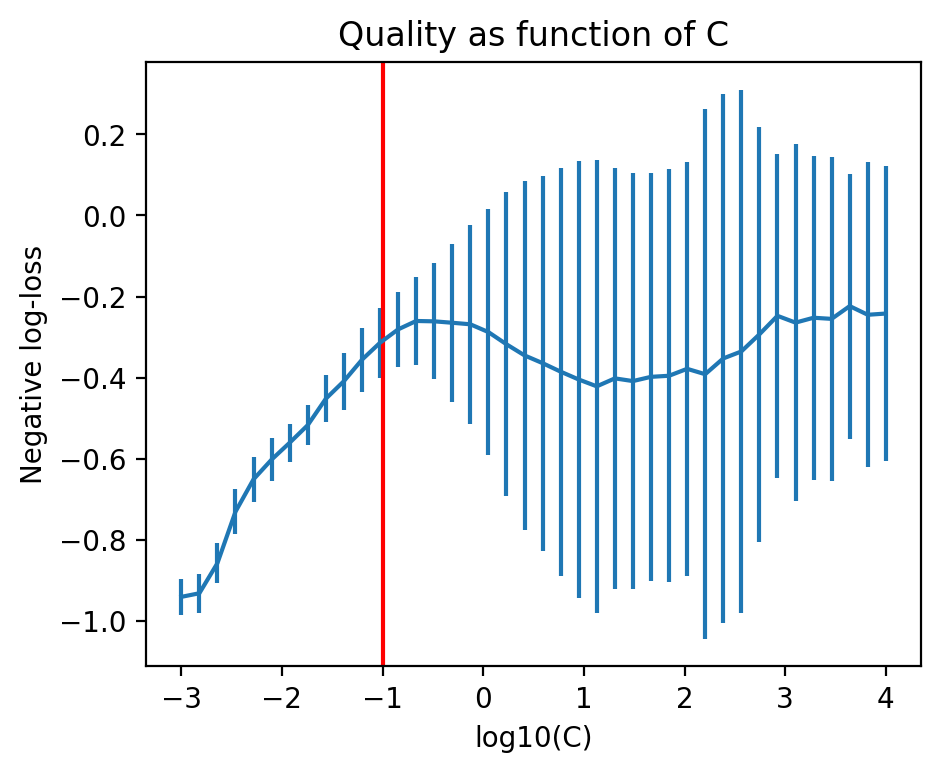

In [165]:
plt.figure(figsize=(5, 4), dpi=200)
c_grid = gs.param_grid['C']
plt.errorbar(np.log10(c_grid), gs.cv_results_['mean_test_score'], gs.cv_results_['std_test_score'])
plt.axvline(x=-1, color='r')
plt.xlabel('log10(C)')
plt.ylabel('Negative log-loss')
plt.title("Quality as function of C")
plt.savefig("../pics/lr_quality_C.png", dpi=200)

In [163]:
C_to_feature_count = []
C_to_coefs = []

for C in grid['C']:
    clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C)
    clf.fit(X_intermediate, Y)
#     C_to_feature_count.append((C, np.sum(np.isclose(clf.coef_, 0.0))))
    C_to_feature_count.append((C, np.sum(np.any(np.logical_not(np.isclose(clf.coef_, 0)), axis=0))))
    C_to_coefs.append((C, clf.coef_))

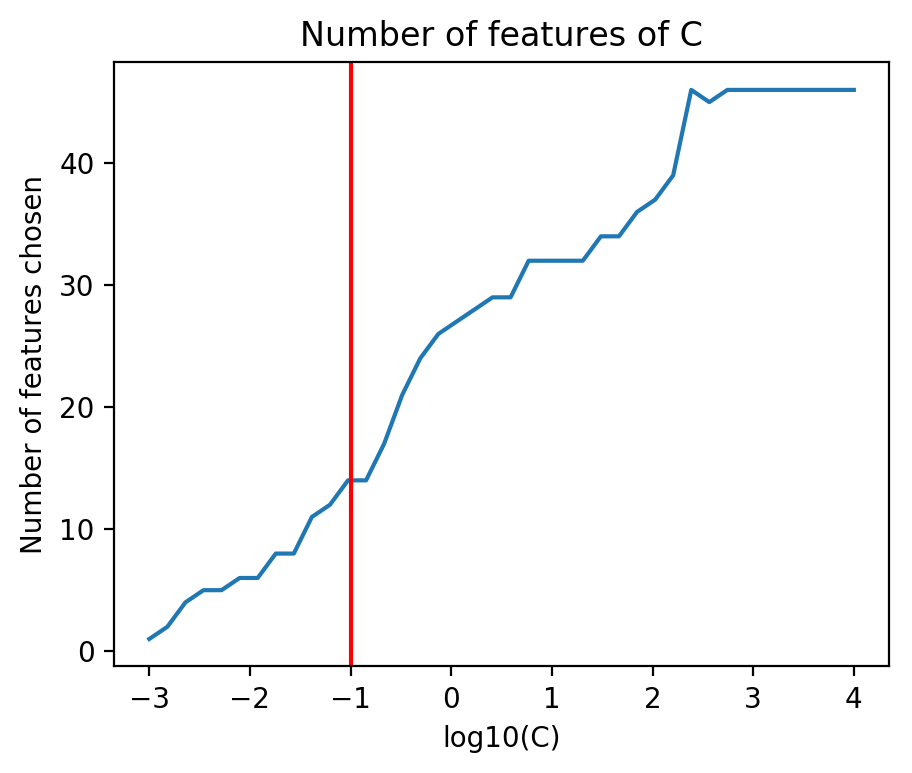

In [166]:
plt.figure(figsize=(5, 4), dpi=200)
plt.plot(np.log10([t[0] for t in C_to_feature_count]),
         [t[1] for t in C_to_feature_count])
plt.axvline(x=-1, color='r')
plt.xlabel('log10(C)')
plt.ylabel('Number of features chosen')
plt.title("Number of features of C")
plt.savefig("../pics/lr_n_features_C.png", dpi=200)

Получаем, что на $C=0.1$ имеем приемлимое качество. Обучим GLE на тех фичах, которые дали ненулевой вклад. Этому регуляризатору соответствует

In [126]:
super_C = min(C_to_coefs, key=lambda x: abs(0.1 - x[0]))
super_coefs = super_C[1]
# (np.isclose(super_coefs[:50], 0) &
#  np.isclose(super_coefs[50:100], 0) &
#  np.isclose(super_coefs[100:150], 0) &
#  np.isclose(super_coefs[150:], 0))
# np.isclose(super_coefs[:50], 0)
# np.isclose(super_coefs[50:100], 0)
true_number_of_features = sum(np.any(np.logical_not(np.isclose(super_coefs, 0)), axis=0))
feature_index = np.any(np.logical_not(np.isclose(super_coefs, 0)), axis=0)
# feature_index.shape
# Testing again.
clf = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000, C=0.0001)
regd_linear_model_error = sklearn.model_selection.cross_val_score(clf, X_intermediate[:, feature_index], Y, scoring='neg_log_loss', cv=10)
np.mean(regd_linear_model_error)

-0.592258205734594

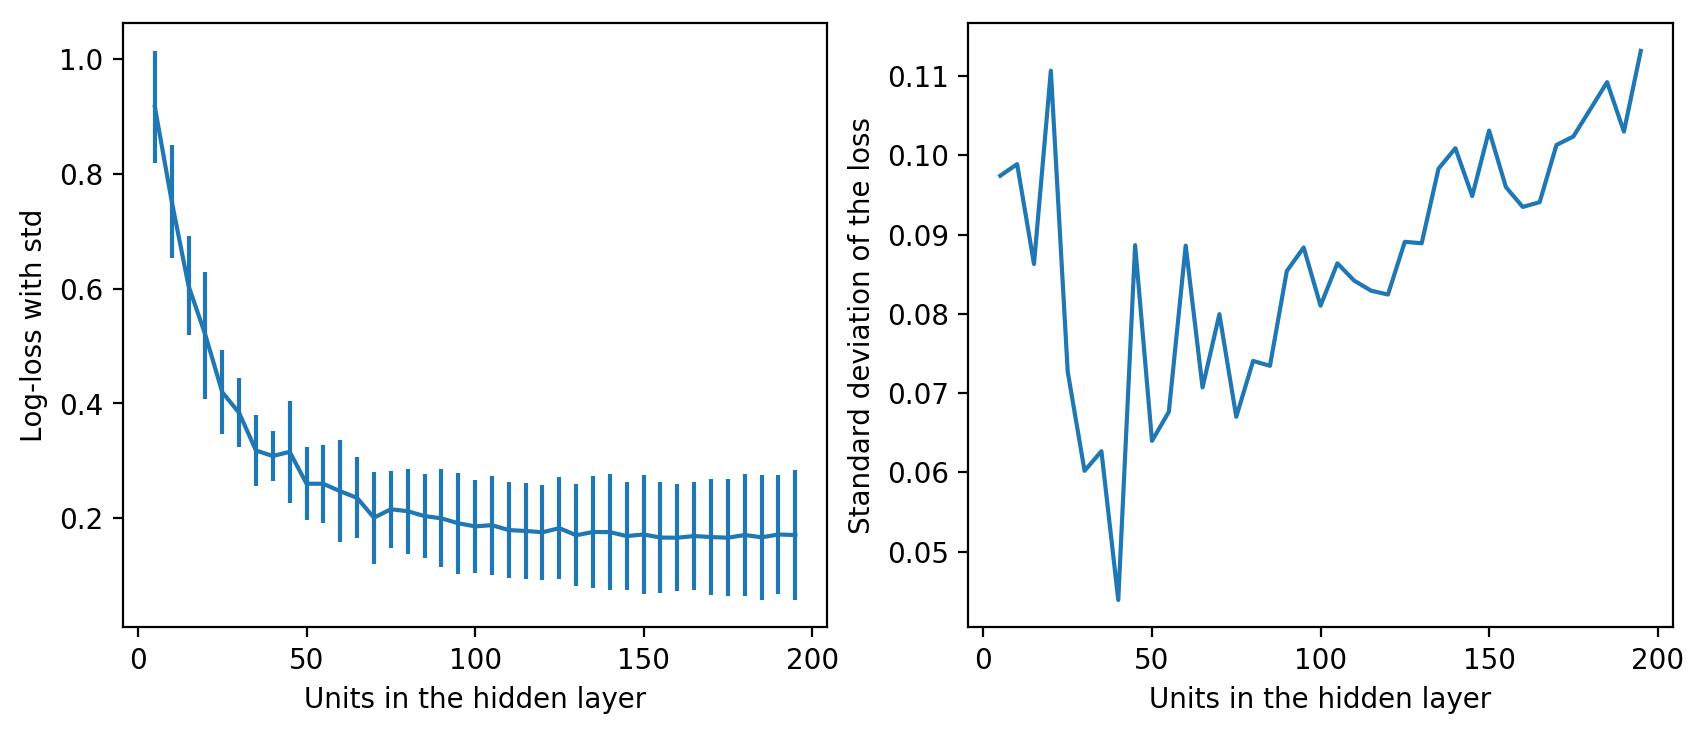

In [174]:
f, axes = plt.subplots(1, 2, dpi=200, sharex=True)
f.set_size_inches(10, 4)
# axes[0].plot(n_units, -np.max(errors, axis=1) / np.mean(regd_linear_model_error))
# axes[0].set_ylabel("Log-loss / log-loss of GLM")
axes[0].errorbar(x=n_units, y=np.mean(errors, axis=1), yerr=np.std(errors, axis=1))
axes[0].set_xlabel("Units in the hidden layer")
axes[0].set_ylabel("Log-loss with std")
axes[1].plot(n_units, np.std(errors, axis=1))
axes[1].set_xlabel("Units in the hidden layer")
axes[1].set_ylabel("Standard deviation of the loss")
# f.xlabel("Number of neurons")
# axes[0].ylabel("Log-loss")
plt.savefig("../pics/loss_and_std_of_n_units_reg.png")

In [142]:
np.mean(regd_linear_model_error)
true_number_of_features

14

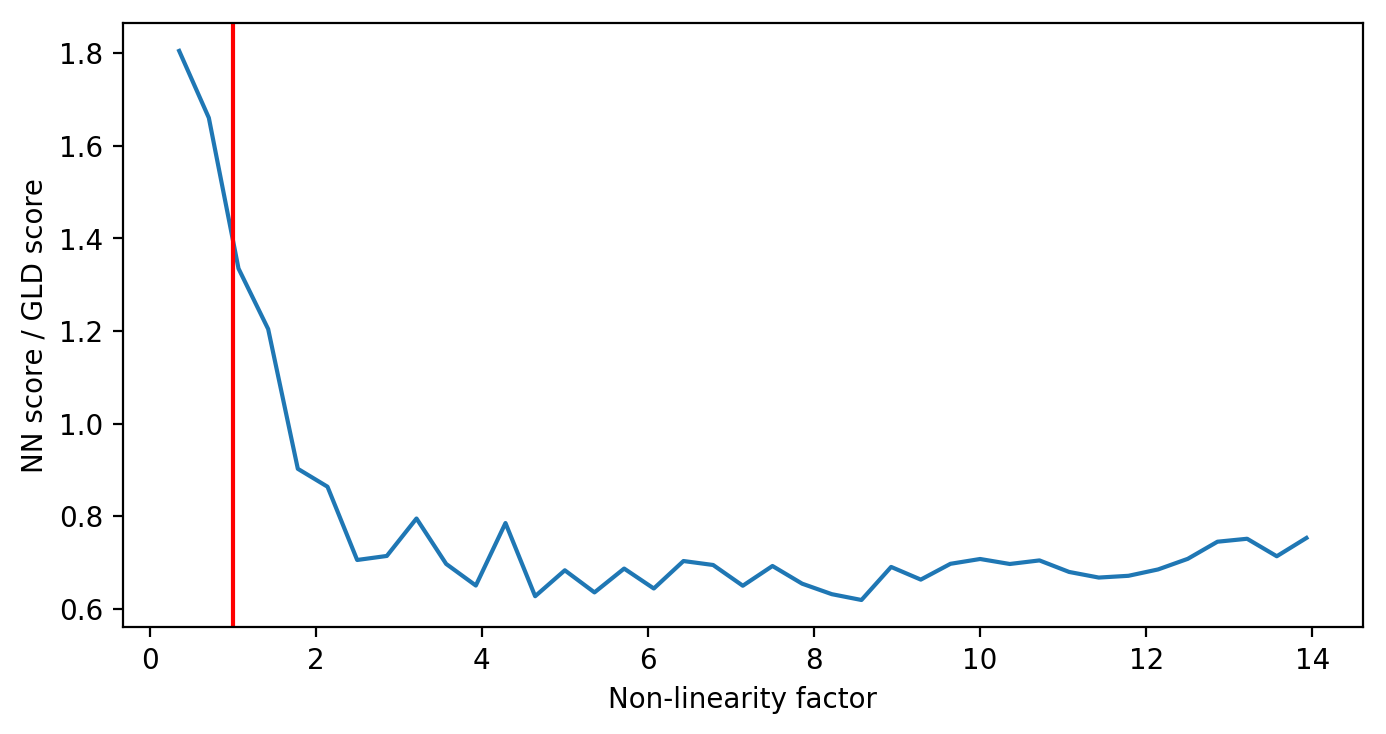

In [177]:
f, axes = plt.subplots(1, 1, dpi=200, sharex=True)
f.set_size_inches(8, 4)
axes.plot(n_units / true_number_of_features, -np.max(errors, axis=1) / np.mean(regd_linear_model_error))
axes.set_ylabel("NN score / GLD score")
axes.axvline(x=1, color='r')
# axes[1].plot(n_units / true_number_of_features, np.std(errors, axis=1))
# axes[1].set_ylabel("std of NN score")
plt.xlabel("Non-linearity factor")
plt.savefig("../pics/loss_and_std_of_nl_factor.png")

# Графики

## Модель с промежуточным пространством

## Качество на нейронке

In [ ]:
score_tuples = [(k, v) for k, v in scores.items()]
score_tuples = sorted(score_tuples, key = lambda x: x[0])
X = np.array([t[0] for t in score_tuples])
score_arrays = np.array([t[1] for t in score_tuples])

In [ ]:
plt.figure(figsize=(10, 8))
plt.errorbar(X, np.mean(score_arrays, axis=1), yerr=np.std(score_arrays, axis=1))
plt.xlabel("Hidden layer neurons count")
plt.ylabel("Negative log-loss")